In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sliced.datasets import make_cubic
from sliced import SlicedInverseRegression
from sliced import SlicedAverageVarianceEstimation
from sliced import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y

In [3]:
x1Restruct_Fun=np.zeros([602,5112])
x2Restruct_Fun=np.zeros([602,5112])

#x1 (0th~5112th column as x)
for i in range (0,602):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x1Restruct_Fun[i][j]=a[j]

#x2 (5112th~10224th column as x)
for i in range (3,605):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2Restruct_Fun[i-3][j]=b[j]
        
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(602, 5112)
(602, 5112)


In [4]:
YRestruct_Fun=np.zeros([599,5112])
for i in range (0,599):
    for j in range (0,5112):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+3][j]
print(np.shape(YRestruct_Fun))

(599, 5112)


In [5]:
XRestruct_Fun=np.zeros([599,10224])
for i in range (0,599):
    for j in range (0,5112):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (5112,10224):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-5112]
print(np.shape(XRestruct_Fun))

(599, 10224)


In [6]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([539,10224])
Yhat_train = np.zeros([539,5112])

for i in range (0,539):
    for j in range (0,5112):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i][j+5112] = Xhat[i][j+5112]
        Yhat_train[i][j] = Yhat[i][j]

In [7]:
###
#cal_PMf  
###
XR=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    XR[i]=a.T

###
#obs_PMf
###
YR=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    YR[i]=a.T
    
Xh=XR
Yh=YR
Xhat_val = np.zeros([61,10224])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,10224])
Yhat_test = np.zeros([61,5112])
        
for i in range (544,605):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*(i-3)+72*j:5112*(i-3)+72*j+72])
        for k in range (0,72):
            Xhat_val[i-544][j*72+k]=a[k]
    for j in range (0,5112):
        Xhat_val[i-544][5112+j] = Xh[i][j]
        Yhat_val[i-544][j] = Yh[i][j]     
        
for i in range (544,605):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*(i-3)+72*j:5112*(i-3)+72*j+72])
        for k in range (0,72):
            Xhat_test[i-544][j*72+k]=a[k]
    for j in range (0,5112):
        Xhat_test[i-544][5112+j] = Xh[i][j]
        Yhat_test[i-544][j] = Yh[i][j]

In [8]:
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(539, 10224)
Yhat_train
(539, 5112)
Xhat_val
(61, 10224)
Yhat_val
(61, 5112)
Xhat_test
(61, 10224)
Yhat_test
(61, 5112)


## Sparse and Expend data

In [9]:
X1hat_train = np.zeros([539,5112])
X2hat_train = np.zeros([539,5112])
X1hat_test = np.zeros([61,5112])
X2hat_test = np.zeros([61,5112])
for i in range (0,539):
    for j in range (0,5112):
        X1hat_train[i][j] = Xhat_train[i][j]
    for j in range (5112,10224):
        X2hat_train[i][j-5112] = Xhat_train[i][j]
for i in range (0,61):
    for j in range (0,5112):
        X1hat_test[i][j] = Xhat_test[i][j]    
    for j in range (5112,10224):
        X2hat_test[i][j-5112] = Xhat_test[i][j]
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))

X1hat_train
(539, 5112)
X2hat_train
(539, 5112)
X1hat_test
(61, 5112)
X2hat_test
(61, 5112)


In [10]:
new_x=np.zeros([539*72,10224]) #38880
new_y=np.zeros([539*72,5112]) #38880
#new_x : 0th~5112th column
for i in range (0,72):
    for j in range (0,539):
        for k in range (0,5112):
            new_x[539*i+j][k]=X1hat_train[j][k]
#new_x : 5112th~10224th column
for i in range (0,72):
    for j in range (0,539):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_x[539*i+j][5112+k]=X2hat_train[j][k]
#new_y
for i in range (0,72):
    for j in range (0,539):
        for k in range (0,5112):
            new_y[539*i+j][k]=YRestruct_Fun[j][k]         

print(np.shape(new_x))
print(np.shape(new_y))

(38808, 10224)
(38808, 5112)


In [11]:
new_exx=np.zeros([61*72,10224]) #38880
new_eyy=np.zeros([61*72,5112]) #38880
#new_exx : 0th~5112th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,5112):
            new_exx[61*i+j][k]=X1hat_test[j][k]
#new_exx : 5112th~10224th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_exx[61*i+j][5112+k]=X2hat_test[j][k]
#new_eyy
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,5112):
            new_eyy[61*i+j][k]=Yhat_test[j][k]         

print(np.shape(new_exx))
print(np.shape(new_eyy))

(4392, 10224)
(4392, 5112)


# Original Data

In [12]:
error1 = mean_absolute_error(Xhat_test[:,5112:], Yhat_test)
error2 = mean_squared_error(Xhat_test[:,5112:], Yhat_test)
print('testing data MAE is ',error1)
print('testing data MAE is ',error2)

testing data MAE is  6.919742865451666
testing data MAE is  90.30246788296535


# Mix Model

## 公式解（PCA + Linear regression）

In [13]:
x = new_x
y = new_y
xt = new_exx
yt = Yhat_test

In [14]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [15]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        fit95 = np.zeros([61,5112])
        for i in range (0,72):
            for j in range (0,61):
                for k in range (0,71):
                    fit95[j][72*k+i]=fit[61*i+j][72*k+i]
        mae = np.mean(abs(fit95-yt))
        mse = np.mean((fit95-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [16]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  85.0 % Y =  85.0 % have the min MAE error : 5.497588003617162
(0.85, 0.85, 5.497588003617162)
test data on x =  85.0 % Y =  85.0 % have the min MSE error : 54.512338228420944
(0.85, 0.85, 54.512338228420944)


## Gradient descent (loss = MAE)

In [118]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [119]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [120]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([5112,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

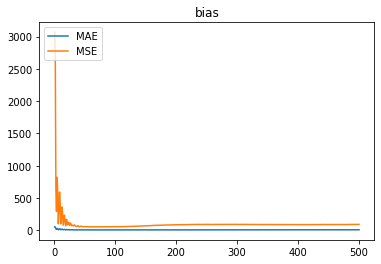

In [121]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [122]:
#new
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.300685247589891
testing data MAE is  53.075186619804434


## Gradient descent (loss = MSE)

In [123]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [124]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [125]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([5112,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

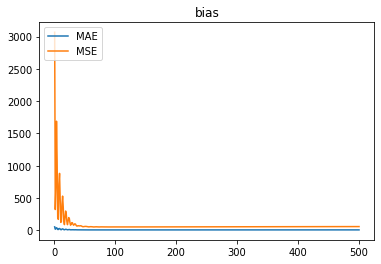

In [126]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [127]:
#new
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.232853934257263
testing data MAE is  50.707704793805284


## Gradient descent (loss = Huber loss)

In [128]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [129]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [130]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([5112,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

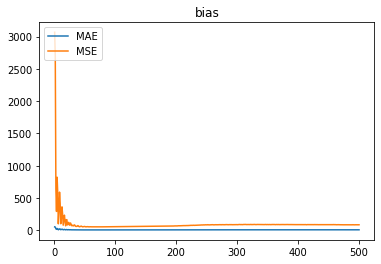

In [131]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [132]:
#new
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.296545529580429
testing data MAE is  52.92543315879946


# Function on Function Model

## 公式解（PCA + Linear regression）

In [133]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [134]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [135]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        
        mae = np.mean(abs(fit-yt))
        mse = np.mean((fit-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [136]:
#new
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  85.0 % Y =  85.0 % have the min MAE error : 5.128618387106426
(0.85, 0.85, 5.128618387106426)
test data on x =  85.0 % Y =  85.0 % have the min MSE error : 44.62122055673008
(0.85, 0.85, 44.62122055673008)


## Gradient descent (loss = MAE)

In [137]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [138]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [139]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([10224,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

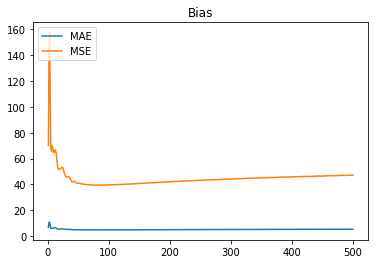

In [140]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [141]:
#new
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.745831698105155
testing data MAE is  39.42391422275325


## Gradient descent (loss = MSE)

In [142]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [143]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [144]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([10224,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

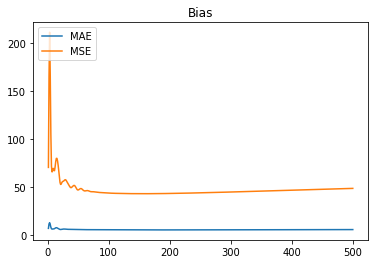

In [145]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [146]:
#new
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.023895552153921
testing data MAE is  42.75738395792819


## Gradient descent (loss = Huber loss)

In [147]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [148]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [149]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([10224,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

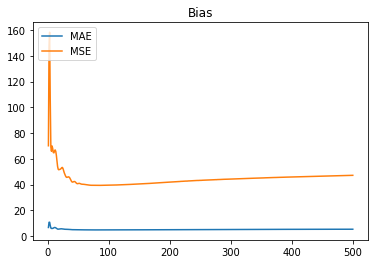

In [150]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [151]:
#new
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.74307716819453
testing data MAE is  39.3592926031027


# PLS Model

In [154]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [155]:
test_error_MAE = 100*np.ones(50)
test_error_MSE = 100*np.ones(50)
for n in range (1,51):
    model = PLSRegression(n_components=n,max_iter=1000)
    model.fit(x, y)

    xf=Xhat_test
    xfit=model.predict(xf)
    
    after_MAE=np.nanmean(abs(xfit-yt))
    after_MSE=np.nanmean((xfit-yt)**2)
    
    test_error_MAE[n-1] = after_MAE
    test_error_MSE[n-1] = after_MSE

In [156]:
#new
print('test data on n = ', np.argmin(test_error_MAE)+1, 'have the min MAE error : ', min(test_error_MAE))
print('test data on n = ', np.argmin(test_error_MSE)+1, 'have the min MSE error : ', min(test_error_MSE))

test data on n =  10 have the min MAE error :  5.098487070718634
test data on n =  10 have the min MSE error :  44.37742227635948


# SIR Model

In [157]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [158]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.90
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = np.zeros(3)
yper[0] = 0.95
yper[1] = 0.99
yper[2] = 0.995
slices = np.zeros(5)
slices[0] = 10
slices[1] = 20
slices[2] = 30
slices[3] = 40
slices[4] = 50
test_error_MAE = 100*np.ones(15)
test_error_MSE = 100*np.ones(15)
index_MAE = []
index_MSE = []

In [159]:
for q in range (0,5):
    for r in range(0,3):
        pca_x = PCA(n_components=xper[q])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        a = x_pca.shape[1]
        
        pca_y = PCA(n_components=yper[r])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        b = y_pca.shape[1]

        xt_pca=pca_x.transform(xt)

        xt_svr = np.zeros([5,61,b])
        #5是因為有5種n_slices
        for j in range (0,5):
            for i in range (0,b):
                sir_x = SlicedInverseRegression(n_slices=slices[j])
                sir_x.fit(x_pca, y_pca[:,i])
                x_sir = sir_x.transform(x_pca)
                   
                svr = SVR()
                svr.fit(x_sir, y_pca[:,i])
                
                xt_sir = sir_x.transform(xt_pca) 
                xt_svr[j][:,i]=svr.predict(xt_sir)
        error1 = np.zeros(5)
        error2 = np.zeros(5)
        for i in range (0,5):
            yt_inv = pca_y.inverse_transform(xt_svr[i])
            error1[i] = np.mean(abs(yt_inv-yt))
            error2[i] = np.mean((yt_inv-yt)**2)

        n1 = 10*(np.argmin(error1)+1)
        n2 = 10*(np.argmin(error2)+1)
        min1 = min(error1)
        min2 = min(error2)
        index_MAE.append((xper[q], yper[r], n1, min1))    
        index_MSE.append((xper[q], yper[r], n2, min2)) 
        test_error_MAE[3*q+r] = min1
        test_error_MSE[3*q+r] = min2

In [160]:
#new
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on n_slices = ', index_MAE[f1][2], ', x = ', index_MAE[f1][0], '% , y = ', index_MAE[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(index_MAE[f1])
print('test data on n_slices = ', index_MSE[f2][2], ', x = ', index_MSE[f2][0], '% , y = ', index_MSE[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(index_MSE[f2])

test data on n_slices =  20 , x =  0.9 % , y =  0.95 % have the min MAE error : 5.2863628983119835
(0.9, 0.95, 20, 5.2863628983119835)
test data on n_slices =  20 , x =  0.9 % , y =  0.95 % have the min MSE error : 47.44604439593329
(0.9, 0.95, 20, 47.44604439593329)


# CNN Model

In [161]:
Xhat_train_n = np.zeros([71,539,144])
Yhat_train_n = np.zeros([71,539,72])
Xhat_test_n = np.zeros([71,61,144])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,539):
        for k in range (0,72):
            Xhat_train_n[i][j][k] = Xhat_train[j][72*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+72] = Xhat_train[j][5112+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,72):
            Xhat_test_n[i][j][k] = Xhat_test[j][72*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+72] = Xhat_test[j][5112+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val=Xhat_test_n
Yhat_val=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))

Xhat_train
(71, 539, 144)
Yhat_train
(71, 539, 72)
Xhat_test
(71, 61, 144)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 144)
Yhat_val
(71, 61, 72)


## loss = MAE

In [162]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(139*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model3", name="CNN_144hr_MAE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [164]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model3/CNN_144hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

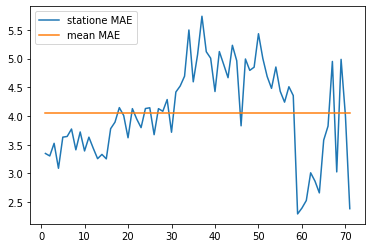

In [165]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

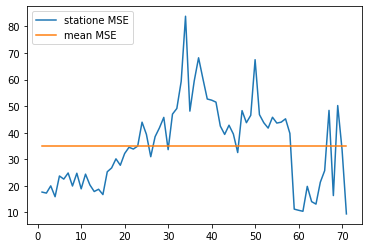

In [166]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [167]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.059326712514313
testing data MAE is  35.13674831390381


## loss = MSE

In [168]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(139*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model3", name="CNN_144hr_MSE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [170]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model3/CNN_144hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

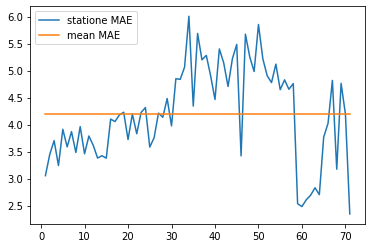

In [171]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

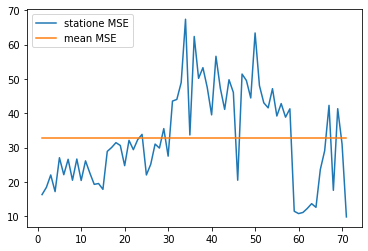

In [172]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [173]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.194805037807411
testing data MAE is  32.926047889279644


## loss = Huber loss

In [174]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(139*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model3", name="CNN_144hr_Huber")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [176]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model3/CNN_144hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

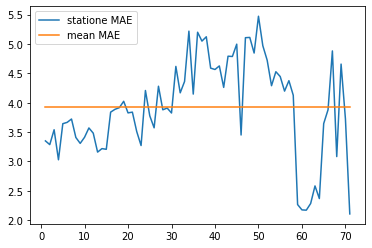

In [177]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

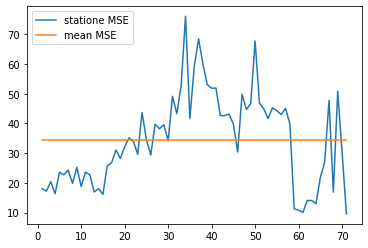

In [178]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [179]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  3.9232183073607967
testing data MAE is  34.485959187359875


# Transformer Model

In [ ]:
Xhat_train_n = np.zeros([71,539,144])
Yhat_train_n = np.zeros([71,539,72])
Xhat_test_n = np.zeros([71,61,144])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,539):
        for k in range (0,72):
            Xhat_train_n[i][j][k] = Xhat_train[j][72*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+72] = Xhat_train[j][5112+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,72):
            Xhat_test_n[i][j][k] = Xhat_test[j][72*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+72] = Xhat_test[j][5112+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

In [ ]:
Xhat_train_n0 = np.zeros([71, 539, 216])
Xhat_val_n0 = np.zeros([71, 61, 216])
Xhat_test_n0 = np.zeros([71, 61, 216])
for k in range(0,71):
    for i in range (0,539):
        for j in range (0,144):
            Xhat_train_n0[k][i][j] = Xhat_train_n[k][i][j]
        for j in range (144,216):
            Xhat_train_n0[k][i][j] = Yhat_train_n[k][i][j-144]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,144):
            Xhat_val_n0[k][i][j] = Xhat_val_n[k][i][j]
        for j in range (144,216):
            Xhat_val_n0[k][i][j] = Yhat_val_n[k][i][j-144]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,144):
            Xhat_test_n0[k][i][j] = Xhat_test_n[k][i][j]
        for j in range (144,216):
            Xhat_test_n0[k][i][j] = Yhat_test_n[k][i][j-144]
print('Xhat_train')
print(np.shape(Xhat_train_n0))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n0))
print('Yhat_test')
print(np.shape(Yhat_test_n))
print('Xhat_val')
print(np.shape(Xhat_val_n0))
print('Yhat_val')
print(np.shape(Yhat_val_n))

## loss = MAE

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(144,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:144])
        ouput = self.layer2(ouput, x[:,144:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_144hr_MAE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [2]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model/Transformer_144hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

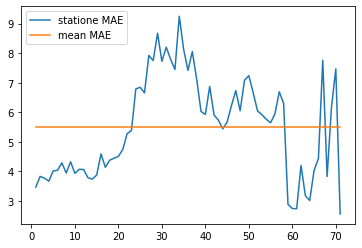

In [3]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

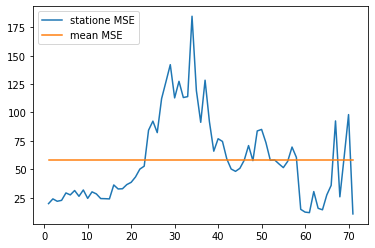

In [4]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [5]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.508024484338895
testing data MAE is  58.451557951913756


## loss = MSE

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(144,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:144])
        ouput = self.layer2(ouput, x[:,144:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_144hr_MSE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [6]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model/Transformer_144hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

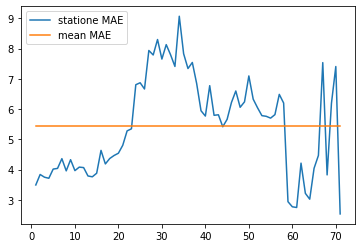

In [7]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

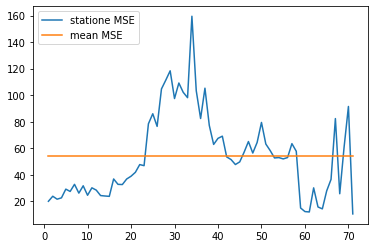

In [8]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [9]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.450614425497995
testing data MAE is  53.93901365575656


## loss = Huber loss

In [8]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(144,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:144])
        ouput = self.layer2(ouput, x[:,144:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_144hr_Huber")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [10]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model/Transformer_144hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

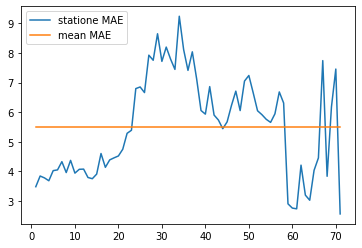

In [11]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

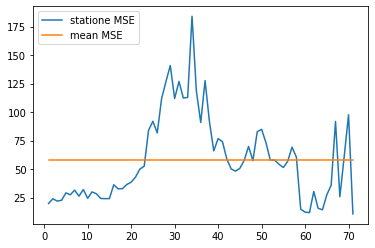

In [12]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [13]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.509578281724957
testing data MAE is  58.20745533956608
